## Toxic Comment Classification

## Intro 
I am quite new in the field of data science and specially transformers are a very new concept to me. During my exploration for learning more about BERT, I noticed most of the material present on kaggle either discuss the underlying logics and modules in BERT model, (which is necessary for begginers) or they present blocks of code without much details. This material is an attempt to bridge the gap from the very basics and theory of BERT model to practicality of a simple model. <br>
A lot of the work in this notebook is inspired by the work of [chumajin](https://www.kaggle.com/chumajin) from [this notebook](https://www.kaggle.com/chumajin/pytorch-bert-beginner-s-room). I would like to thank him here and would add that I have adapt it to our problem in this competetion. I have also added more visualization to see the imporvements of the models over iterations in epochs and during different folds. 

### Objective
Creating a model which predicts the probability of each type of toxicity for each comment.

This notebook is presented to two parts. I have separted it in two parts, due to memory limitations in kaggle. You can run either part I or part II independantly. <br>
In **part I** I try to explain the primary steps we need to take for handling similar tasks, for binary classification of different labels. The model in this part runs only for one distribuation of train set and validation set. and you can see the inital performance results(auc score) we get from this model. <br>
In **part II**, I have braught all the necessary blocks of code from part I and then show how 5 models can be developed for different choices of train set and validation set as in k_fold (k = 5). The probablites for all types of toxicity for each comment is then estimated as mean value from these 5 models. 



### Parameters affecting simulation time
For running this noteboook quickly, to see how it works, in both part I and part II, you can reduce the training set to the limited number of rows. I took 200 rows in part I and 2000 in part II.<br> 
The reason for having it very low in part I is that the code opts for eductional resons rather than being efficient. Therefore, it reads in many different variables and cause the cuda memory crash if we go for more than 200 rows. This gives us an unimpressive results for part I. (accuracy 86%) <br>
In part II, code is more consice compared to part I, and it's possible to raise number of rows to include the whole training set. However, I keep it limited to 2000, so you manage to get a fairly good result (94% accuracy and 0.988 auc score) in 22 min of simulation. <br>
You can have (epochs = 5, k = 5) and see how the accuracy and losses imporve in different epochs. The accuracy and loss are in an acceptable range, as this notebook is not concerned about reaching the state-of-art results. <br>

Hope that you find it useful and if so, please don't forget to upvote this note book, it makes my day! :-)

## PART I
## 1. Prepare the data
### a. Loading libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

We set a seed for reproducability of the results.

In [ ]:
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [ ]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip', nrows = 200 )
train.head()

In [ ]:
temp = train[train['toxic'] == 1]
temp.head()

In [ ]:
print(len(train['comment_text'][10]), 'Total Characters')
train['comment_text'][10]

A comment can be toxic, severe_toxic, obscene and insult at the same time. So the class for each comment is not limited to one.
<br>Now let's check the values for each column in train dataset.

In [ ]:
labels = train.drop(['id', 'comment_text'], axis = 1)
unique_values = lambda x: train[x].unique()
[unique_values(col) for col in labels.columns.tolist()]

In [ ]:
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', nrows = 100)
test.head()

In [ ]:
test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip', nrows = 10)
test_labels.head()

In [ ]:
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip', nrows = 10)
submission.head()

## 2. Summerize data
### a. Descriptive statistics
### Missing values

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

Great! we have no missing value!
### Distribution of each class in the train set and test labels
Let's check how many of each category is found in our training data:

In [ ]:
df_train = train.drop(['id', 'comment_text'], axis = 1)
label_counts = df_train.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))
p = sns.barplot(df_counts.index, df_counts['counts'])
x = plt.xticks(rotation = 60) 
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ ' samples of data', weight = 'bold', fontsize = 18, y = 1.05)
x = ax.set_ylabel('')

Relative percentage gives us a better understanding.

In [ ]:
labels = np.round(df_train.sum()/len(df_train)*100, 1)
labels

In [ ]:
df_test_labels = test_labels.drop(['id'], axis = 1)
count_values = lambda x: np.round(df_test_labels[x].value_counts(normalize = True)*100, 1)
pd.DataFrame([count_values(col) for col in df_test_labels.columns.tolist()])

In [ ]:
train.shape, test.shape

## 3. Prepare Data
### a. Data cleaning 
We need to clean, tokenize and convert the data to tensors. <br>
The function below helps us with:

- Removing hyperlinks, punctuation and numbers
- Tokenizeation

We skip changing it all to lower case and keep the letters sensetive to case. The comment BAD!! has stronger negative emotion in it than bad!! <br>
We also do not remove the stop words, Since with contextual models such as BERT and ROBERTA it is (almost) always better not to process the texts removing stopwords. These models are pretrained with stopwords: if you remove stop words your model may lose the context. This is also true for stemming and lemmatization preprocessing techniques. So we skip them too!

In [ ]:
# text preprocessing helper functions [1]

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    #text = text.lower()
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', '', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
%%time
train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

### b. Dataset and Dataloader
We use 20% of the training data as validation set.

In [ ]:
kfold = 5
train['kfold'] = train.index % kfold
train.index % kfold

In [ ]:
#reset_index creates a column with the name of 'index' and saves the old index values in it and updates the values of index.
#drop = True removes the column 'index' with the old index values. 
p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

In [ ]:
p_train.head()

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
%%time
senten_len = []
for sentence in tqdm(p_train['clean_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

We'll have a look at the distribution of the length for tokenized comments to have an intuation about what to set as max_length for our tokenized comments.

In [ ]:
sns.distplot(senten_len)
plt.xlim([0, 300])
plt.xlabel('Tocken count')

It seems that 200 is good size move on with. 

In [ ]:
max_len = 200

We define a class BertDataSet with Dataset as super class and overwirte the__init_, __ len__ and __ getitem__ function in it. It will get the comment list and relevant toxic labels (6 labels in this case) and creates token ids and attention mask to distinguish the comments from the zero padding.

**torch.tensor vs np.ndarray:** <br>
If you are only interested in efficient and easy way to perform mathematical operations on matrices np.ndarray or torch.tensor can be used interchangeably.

However, torch.tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but (and more importantly) the computational graph leading to these values. This computational graph is then used (using the chain rule of derivatives) to compute the derivative of the loss function w.r.t each of the independent variables used to compute the loss.

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.

In [ ]:
class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [ ]:
train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

Let's have a look what's inside a dataset:

In [ ]:
for a in train_dataset:
    print(a)
    break

Now we set the batch-size for trainig set and validation set. The bigger batch size helps to speed up the computations. However, the results confirm that using small batch sizes achieves the best generalization performance, for a given computation cost. In all cases, the best results have been obtained with batch sizes of 32 or smaller. Often mini-batch sizes as small as 2 or 4 deliver optimal results.

In [ ]:
train_batch = 32
valid_batch = 32

In the code below pin_memory = True to a DataLoader will automatically put the fetched data Tensors in pinned memory, 
and thus enables faster data transfer to CUDA-enabled GPUs. This is best explained in the [NVIDIA blogpost](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/). I will borrow the picture from it. 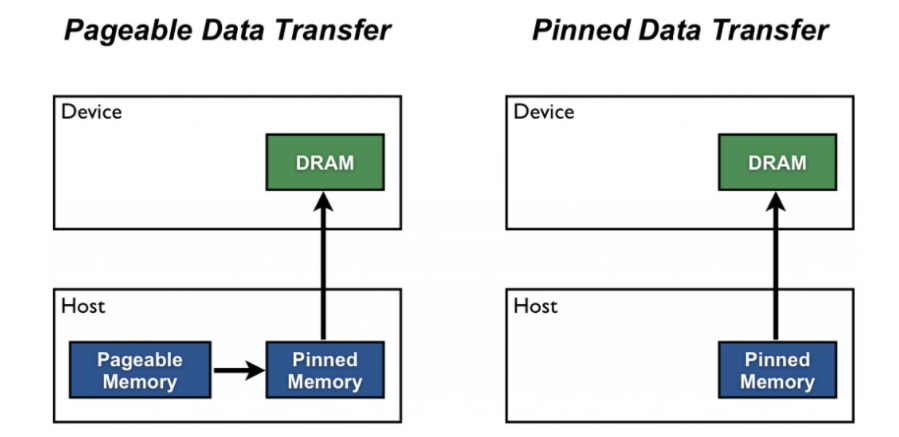<br>
num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processesm

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

Here we can check inside the dataloader:

In [ ]:
%%time
for a in train_dataloader:
    print(a)
    print('id shape in data laoder is',a['ids'].shape)
    break

## 4. BERT Modeling
For faster computation, let's set the device cuda if it is available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
%%time
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)
model.train()

The model makes use of id and mask from token encoding in the trian set. At this state, there is no need to feed in the model with the target values such as toxic, obscene, etc.

In [ ]:
%%time
for a in train_dataloader:
    ids = a['ids'].to(device)
    mask = a['mask'].to(device)
    output = model(ids, mask)
    break

In [ ]:
output

To get the output probabilities, we should use sigmoid function. This can be done either in the model or like here be applied to the output from model. I was first making the mistake and used softmax function. However, in our case a comment can be classified as toxic, obscene and insult at the same time. Hence it's not a multi-classficationm and therefore, this is not applicable. <br>
Here is the summary of differences between softmax function and sigmoid funciton. <br>

**Softmax funciton:**<br>
- Used for Multi-classification in the Logistics Regression model
- The probabilities sum will be 1<br>

**Sigmoid funciton:**
- Used for Binary Classification in the Logistic Regression model
- The probabilities sum does not need to be 1

To learn more about them you can read this: https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322

In [ ]:
func.softmax(output['logits'], dim = 1)

In [ ]:
output_probs = func.softmax(output['logits'], dim = 1)

In [ ]:
torch.max(output_probs, dim = 1)

## 5. Functions for training and validating
### a. Setting up some parameters

In [ ]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

We use the learning rate parameter as set above for 10% of total training time. We then decrease the learning rate gradualy to zero. 

In [ ]:
train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [ ]:
le = []
for b in tqdm(range(epochs)):
    for a in train_dataloader:
        le.append(scheduler.get_last_lr())
        scheduler.step()
plt.plot(np.arange(len(le)), le)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

### b. Training function
You can find more details about some keywords in this block of code below it.

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

**amp** stands for automatic mixed precision. <br>
To learn more about the **autocast** read this link: <br>
https://pytorch.org/docs/stable/amp.html <br>
in short: Instances of autocast serve as context managers or decorators that allow regions of your script to run in mixed precision, where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
autocast should wrap only the forward pass(es) of your network, including the loss computation(s). Backward passes under autocast are not recommended. <br>
<br>
**with** statement in Python is used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams. Here is a link to learn more about it.<br>
https://www.geeksforgeeks.org/with-statement-in-python/<br>

**Non-Blocking** allows you to overlap compute and memory transfer to the GPU. Pinned Memory allows the non-blocking calls to actually be non-blocking.<br>

Why using **var.detach().cpu().numpy()** and not var.numpy() only? <br>
because we get an error. The main reason behind this choice presumably is to avoid confusing new comers. People not very familiar with requires_grad and cpu/gpu Tensors might go back and forth with numpy. For example doing pytorch -> numpy -> pytorch and backward on the last Tensor. This will backward without issue but not all the way to the first part of the code and won’t raise any error.
So the choice has been made to force the user to detach() to make sure they want to do it and it’s not a typo/other library that does this tranformation and breaks the computational graph.<br>

**optimizer.step():** it performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. As an example, the update rule for SGD is defined here:<br>
https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63 <br>

**loss.backward()** Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call. Note that following the first .backward call, a second call is only possible after you have performed another forward pass.

### Gradient Scaling
If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.<br>

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.<br>

Each parameter’s gradient (.grad attribute) should be unscaled before the optimizer updates the parameters, so the scale factor does not interfere with the learning rate.<br>

**step()** carries out the following two operations:
1. Internally invokes unscale_(optimizer) (unless unscale_() was explicitly called for optimizer earlier in the iteration). As part of the unscale_(), gradients are checked for infs/NaNs.
2. If no inf/NaN gradients are found, invokes optimizer.step() using the unscaled gradients. Otherwise, optimizer.step() is skipped to avoid corrupting the params.

### c. Validating function
validating function is quite similar to training function. The difference is that there is no back-propagation and optemization for parameters in it. 

In [ ]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

## 6. Training the model
### a. Run training function

In [ ]:
%%time

best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

### b. Plotting the results

In [ ]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 


## 7. Evaluation
We use auc as a metric of evaluation in this report.

In [ ]:
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [ ]:
auc(fpr, tpr)

## PART II

You can start to run the notebook from here until the end. I have copied all the necessary parts from part I in this notebook. The objective here is to show how the model works for 5 different folds. epochs is set to 5 and the first 2000 rows of the trianing set is used. Feel free to change these parameters and see how it affects the accuracy.

In [ ]:
%%time
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip', nrows = 2000)
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', nrows = 100)
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

SEED = 34
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
random_seed(SEED)

def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

kfold = 5
train['kfold'] = train.index % kfold

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
max_len = 200

class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

epochs = 5
train_batch = 32
valid_batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_train)*6)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

## 8. Repeat training for k-fold

To improve our model we repeat the same process of training for each fold of k-folds.

In [ ]:
%%time

best_scores = []
for fold in tqdm(range(0,5)):

    # initializing the data
    p_train = train[train['kfold'] != fold].reset_index(drop = True)
    p_valid = train[train['kfold'] == fold].reset_index(drop = True)

    train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
    valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 4, pin_memory = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, shuffle = False, num_workers = 4, pin_memory = True)

    model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-cased", num_labels = 6)
    model.to(device)
    
    LR = 2e-5
    optimizer = AdamW(model.parameters(), LR,betas = (0.9, 0.999), weight_decay = 1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch * epochs)
    num_steps = int(train_steps * 0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
    
    best_score = 1000
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_valid_probs = []
    
    print("-------------- Fold = " + str(fold) + "-------------")
    
    for epoch in tqdm(range(epochs)):
        print("-------------- Epoch = " + str(epoch) + "-------------")

        train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
        valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        print('train losses: %.4f' %(train_loss), 'train accuracy: %.3f' %(train_acc))
        print('valid losses: %.4f' %(valid_loss), 'valid accuracy: %.3f' %(valid_acc))

        if (valid_loss < best_score):

            best_score = valid_loss
            print("Found an improved model! :)")

            state = {'state_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'best_score':best_score
                    }

            torch.save(state, "model" + str(fold) + ".pth")
            best_valid_prob = valid_probs
            torch.cuda.memory_summary(device = None, abbreviated = False)
        else:
            pass


    best_scores.append(best_score)
    best_valid_probs.append(best_valid_prob)
    
    ##Plotting the result for each fold
    x = np.arange(epochs)
    fig, ax = plt.subplots(1, 2, figsize = (15,4))
    ax[0].plot(x, train_losses)
    ax[0].plot(x, valid_losses)
    ax[0].set_ylabel('Losses', weight = 'bold')
    ax[0].set_xlabel('Epochs')
    ax[0].grid(alpha = 0.3)
    ax[0].legend(labels = ['train losses', 'valid losses'])

    ax[1].plot(x, train_accs)
    ax[1].plot(x, valid_accs)
    ax[1].set_ylabel('Accuracy', weight = 'bold')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(labels = ['train acc', 'valid acc'])

    ax[1].grid(alpha = 0.3)
    fig.suptitle('Fold = '+str(fold), weight = 'bold') 

In [ ]:
best_scores

In [ ]:
print('Mean of',kfold, 'folds for best loss in', epochs, 'epochs cross-validation folds is %.4f.' %(np.mean(best_scores)))

## 9. Evaluation for k-models

We use ensemble for evaluating k-models in the validation set.

In [ ]:
def predicting(test_dataloader, model, pthes):
    allpreds = []
    
    for pth in pthes:
        state = torch.load(pth)
        model.load_state_dict(state['state_dict'])
        model.to(device)
        model.eval()
        preds = []
        with torch.no_grad():
            for a in test_dataloader:
                ids = a['ids'].to(device)
                mask = a['mask'].to(device)
                output = model(ids, mask)
                output = output['logits'].squeeze(-1)
                output_probs = torch.sigmoid(output)
                preds.append(output_probs.cpu().numpy())
            preds = np.concatenate(preds)
            allpreds.append(preds)
      
    return allpreds

In [ ]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

In [ ]:
allpreds = predicting(valid_dataloader, model, pthes)

Taking the avarage of probabilities from k-models for each sample in the validation set.

In [ ]:
valid_probs = np.zeros((len(p_valid),6))
for i in range(kfold):
    valid_probs += allpreds[i]
valid_probs = valid_probs / kfold

In [ ]:
valid_probs = np.asarray(valid_probs).flatten()

In [ ]:
#valid_probs = allpreds[0].flatten() #This line is used when trianing for one model and not k-fold model 
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, valid_probs)
print('auc score for kfold =', kfold, 'models is: %.2f' %(auc(fpr, tpr)*100))

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

## 10. Inference

In [ ]:
class BERTinferenceDataSet(Dataset):
    
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_sent = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, #[SEP][PAD]
                                         max_length = max_len,
                                         pad_to_max_length = True,
                                         truncation = True)

        ids = torch.tensor(bert_sent['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_sent['attention_mask'], dtype = torch.long)

        return{
            'ids' : ids,
            'mask' : mask
             }

In [ ]:
test_batch = 32
test_dataset = BERTinferenceDataSet(test['clean_text'])
test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers = 4, pin_memory = True)
pthes = [os.path.join("../input/bert-model-for-dummies",s) for s in os.listdir('../input/bert-model-for-dummies') if ".pth" in s]
pthes


In [ ]:
allpreds = predicting(test_dataloader, model, pthes)

In [ ]:
print('allpreds is an array with the shape of:',len(allpreds), 'x',len(allpreds[0]), 'x',len(allpreds[0][0]))
allpreds[0][0]

We take the average of the probabilities in 5 folds.

In [ ]:
preds = np.zeros((len(test_dataset),6))
for i in range(kfold):
    preds += allpreds[i]
preds = preds / kfold

In [ ]:
results = pd.DataFrame(preds)
submission = pd.concat([test,results], axis = 1).drop(['comment_text', 'clean_text'], axis = 1)
submission.rename(columns = { 0:'toxic', 1:'severe_toxic', 2:'obscene', 3:'threat', 4:'insult', 5:'identity_hate'}, inplace = True)
submission.to_csv("submission.csv", index = False)

## 11. Summary
Here we presented a simple bert model for comment toxicity classification. A comment can be classified with multi-label and therefore this is an example of binary classification with multiple labels (not multi-classficaiton). <br>
You can run part I and part II of the notebook independantly. <br>
The best score(0.9796) achieved after running part II, with trianing the model with all the trainnig data (not reducing it to fewer rows) and having epochs = 1. The code is available in version 8. I didn't try with more epochs, because the trianing time would exceed 5h which was not the major intention with this notebook. <br>
Training the model with 2000 training samples and epochs = 5 results in a faster computation and gives the socre: 0.94311.

## 12. Useful links

[1] https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert <br>
[2] http://jalammar.github.io/illustrated-bert/ <br>
[3] https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/ <br>
[4] http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ <br>
[5] https://iq.opengenus.org/native-language-identification-dl/